In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
from tensorflow.keras.utils import to_categorical

import random
import sys
import time

import pandas as pd
import numpy as np

import random
import matplotlib.pyplot as plt
import itertools
import glob

tf.keras.backend.set_floatx('float64')

In [2]:
print(tf.__version__)

2.0.0


In [3]:
path = r'/home/giang/Lab/Code/Testsets' # use your path
classes = {0:'P0-W0', 1:'P1-W1', 2:'P9-W7', 3:'P14-W0'}

df, x_np, y_np = {}, {}, {}

for i, cls in classes.items():
  print(i, cls)
  all_files = glob.glob(path + "/" + cls + "/*.csv")
  df[i] = pd.concat((pd.read_csv(f, header=None) for f in all_files))
  x_np[i] = np.transpose(np.array(df[i]))
  print(x_np[i].shape)
   
  y_np[i] = np.ones(len(x_np[i])) * i # Target label
  print(y_np[i].shape)

0 P0-W0
(861, 504)
(861,)
1 P1-W1
(743, 504)
(743,)
2 P9-W7
(819, 504)
(819,)
3 P14-W0
(824, 504)
(824,)


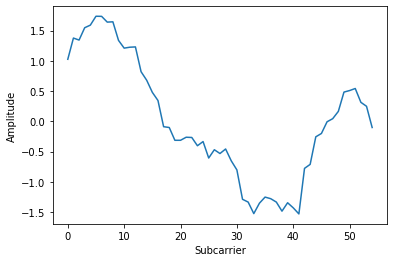

In [4]:
plt.plot(x_np[0][0][0:55])
#plt.plot(x_np[1])
#plt.plot(x_np[2])
#plt.plot(x_np[3])
plt.xlabel("Subcarrier")
plt.ylabel("Amplitude")
plt.show()

In [5]:
num_tasks = min(len(x_np[i]) for i in range(len(classes))) 
print(num_tasks)

743


In [6]:
task_data = {}
task_label = {}
for i in range(num_tasks):
    task_data[i] = np.stack([x_np[k][i] for k in range(len(classes))],axis=0)
    task_label[i] = np.stack([y_np[k][i] for k in range(len(classes))],axis=0)
    task_label[i] = task_label[i].reshape(-1,1)
print(task_data[0].shape)
print(task_label[0].shape)

(4, 504)
(4, 1)


In [7]:
data_label = {}
for i in range(num_tasks):
    data_label[i] = np.concatenate((task_data[i],task_label[i]),axis=1)
    np.random.shuffle(data_label[i])
    task_data[i],task_label[i] = np.split(data_label[i],[-1],axis=1)
    task_label[i] = to_categorical(task_label[i])
print(task_data[0].shape)
print(task_label[0].shape)

(4, 504)
(4, 4)


In [8]:
class MLPModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(50, input_shape=(504,))
        self.hidden2 = keras.layers.Dense(30)
        self.hidden3 = keras.layers.Dense(30)
        self.out = keras.layers.Dense(4)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = keras.activations.relu(self.hidden3(x))
        x = keras.activations.softmax(self.out(x))
        return x

In [9]:
def loss_function(y,pred_y):
    return keras_backend.mean(keras.losses.categorical_crossentropy(y,pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)
    

def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mse = loss_fn(y, logits)
    return mse, logits


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, logits = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss, logits


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss, logits = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return logits, loss

def accuracy_function(y, pred_y):
    return keras.metrics.categorical_accuracy(y, pred_y)


In [10]:
def train_model(model,data,label, epochs=1, lr=0.001, log_steps=1):
    model = model
    optimizer = keras.optimizers.Adam(learning_rate=lr)

    losses = []
    accuracies = []
    for epoch in range(epochs):
        epoch_totalloss = 0
        epoch_totalaccuracy = 0
        start = time.time()
        for i in range(len(data)):
            task_totalloss = 0
            task_totalaccuracy = 0
            for k in range(len(classes)):              
                x = data[i][k,:].reshape(1,-1)
                y = label[i][k]
                logits, task_currloss = train_batch(x, y, model, optimizer)
                task_totalloss += task_currloss
                task_loss = task_totalloss / (k + 1.0)
                task_curraccuracy = accuracy_function(y, logits)
                task_totalaccuracy += task_curraccuracy
                task_accuracy = task_totalaccuracy / (k + 1.0)
            epoch_totalaccuracy += task_accuracy
            epoch_totalloss += task_loss
        epoch_loss = epoch_totalloss/(i+1)
        epoch_accuracy = epoch_totalaccuracy/(i+1)
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)
            
        if epoch % log_steps == 0:
            print('Epoch {}: Loss = {}, Train accuracy = {}, Time to run {} epoch = {:.2f} seconds'.format(
                    epoch+1, epoch_loss, epoch_accuracy, log_steps, time.time() - start))
            start = time.time()
    plt.figure()
    plt.plot(losses)
    plt.title('Loss Vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    plt.figure()
    plt.plot(accuracies)
    plt.title('Train Accuracy Vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    return model,losses, accuracies

Epoch 1: loss = 0.10215504647800708, train accuracy = [0.96971736], Time to run 1 epoch = 120.54 seconds
Epoch 2: loss = 0.03660325317623795, train accuracy = [0.98654105], Time to run 1 epoch = 120.56 seconds
Epoch 3: loss = 0.02792938144215788, train accuracy = [0.98990579], Time to run 1 epoch = 119.82 seconds
Epoch 4: loss = 0.020823918619923828, train accuracy = [0.99427995], Time to run 1 epoch = 120.14 seconds
Epoch 5: loss = 0.02109745033348402, train accuracy = [0.99663526], Time to run 1 epoch = 120.41 seconds


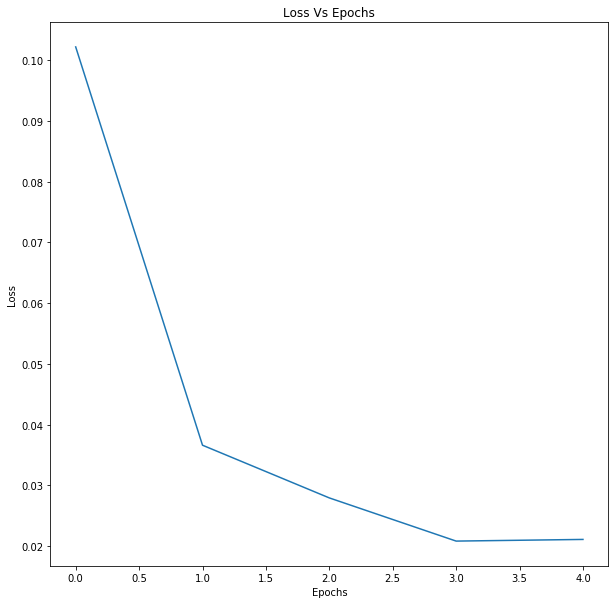

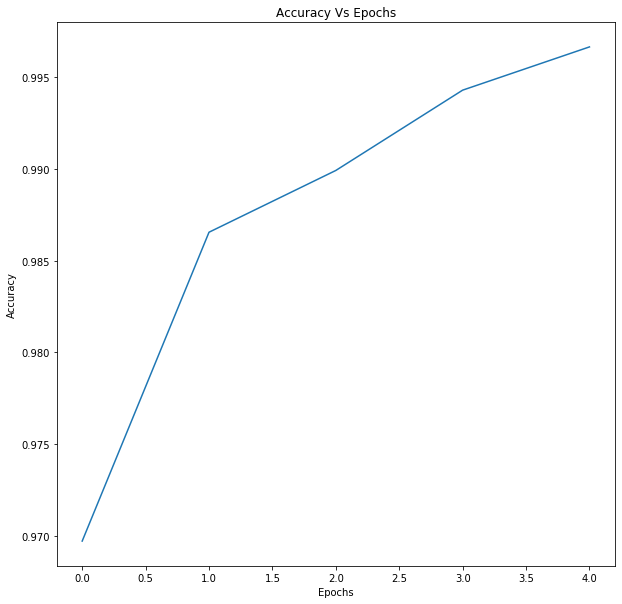

In [25]:
model = MLPModel()
trained, loss, accuracies = train_model(model,task_data,task_label,5)

In [11]:
def copy_model(model, x):
    '''Copy model weights to a new model.
    
    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = MLPModel()
    
    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))
    
    copied_model.set_weights(model.get_weights())
    return copied_model


In [12]:
def train_maml(model, data, label, epochs, lr_inner=0.01, batch_size=1, log_steps=1):
    '''Train using the MAML setup.
    
    The comments in this function that start with:
        
        Step X:
        
    Refer to a step described in the Algorithm 1 of the paper.
    
    Args:
        model: A model.
        epochs: Number of epochs used for training.
        dataset: A dataset used for training.
        lr_inner: Inner learning rate (alpha in Algorithm 1). Default value is 0.01.
        batch_size: Batch size. Default value is 1. The paper does not specify
            which value they use.
        log_steps: At every `log_steps` a log message is printed.
    
    Returns:
        A strong, fully-developed and trained maml.
    '''
    optimizer = keras.optimizers.Adam()
    
    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    losses = []
    accuracies = []
    for epoch in range(epochs):
        epoch_totalloss = 0
        epoch_totalaccuracy = 0
        start = time.time()
        # Step 3 and 4
        for i in range(len(data)):
            z = data[i][0,:].reshape(1,-1)
            model.forward(z)  # run forward pass to initialize weights
            with tf.GradientTape() as test_tape:
                # test_tape.watch(model.trainable_variables)
                # Step 5
                with tf.GradientTape() as train_tape:
                    task_totaltrainloss = 0
                    for k in range(len(classes)):
                        x = data[i][k,:].reshape(1,-1)
                        y = label[i][k]
                        task_currtrainloss, _ = compute_loss(model, x, y) 
                        task_totaltrainloss += task_currtrainloss
                        task_trainloss = task_totaltrainloss/(k+1)
                # Step 6
                gradients = train_tape.gradient(task_trainloss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, z)
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                tf.multiply(lr_inner, gradients[k+1]))
                    k += 2
                # Step 8
                task_totaltestloss = 0
                task_totalaccuracy = 0
                for k in range(len(classes)):                  
                    x = data[i][k,:].reshape(1,-1)
                    y = label[i][k]
                    task_currtestloss, logits = compute_loss(model_copy, x, y)
                    task_totaltestloss += task_currtestloss
                    task_testloss = task_totaltestloss/(k+1)
                    task_curraccuracy = accuracy_function(y, logits)
                    task_totalaccuracy += task_curraccuracy
                    task_accuracy = task_totalaccuracy/(k+1)
            # Step 8
            gradients = test_tape.gradient(task_testloss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Logs
            epoch_totalloss += task_testloss
            epoch_totalaccuracy += task_accuracy
        epoch_loss = epoch_totalloss / (i+1.0)
        epoch_accuracy = epoch_totalaccuracy / (i+1.0)
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)
            
        if epoch % log_steps == 0:
            print('Epoch {}: Loss = {}, Train accuracy = {}, Time to run {} epoch = {}'.format(epoch+1, epoch_loss, epoch_accuracy, log_steps, time.time() - start))
            start = time.time()
    plt.figure()
    plt.plot(losses)
    plt.title('Loss Vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    plt.figure()
    plt.plot(accuracies)
    plt.title('Train Accuracy Vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    return model, losses, accuracies

Epoch 1: Loss = 0.09502734121579631, Train accuracy = [0.97240915], Time to run 1 epoch = 470.40244030952454
Epoch 2: Loss = 0.0531642009105087, Train accuracy = [0.993607], Time to run 1 epoch = 468.9064631462097
Epoch 3: Loss = 0.05444150798172311, Train accuracy = [0.993607], Time to run 1 epoch = 468.99922013282776
Epoch 4: Loss = 0.1782327909244995, Train accuracy = [0.98687752], Time to run 1 epoch = 470.2843177318573
Epoch 5: Loss = 0.0038714136874352023, Train accuracy = [0.99899058], Time to run 1 epoch = 469.50508069992065
Epoch 6: Loss = 0.019562444013115077, Train accuracy = [0.99663526], Time to run 1 epoch = 469.4703679084778
Epoch 7: Loss = 0.0034555836970238717, Train accuracy = [0.99899058], Time to run 1 epoch = 469.404305934906
Epoch 8: Loss = 0.004547005071274467, Train accuracy = [0.99932705], Time to run 1 epoch = 470.5746555328369
Epoch 9: Loss = 0.0005626518457456801, Train accuracy = [1.], Time to run 1 epoch = 469.1021752357483
Epoch 10: Loss = 7.3889557725855

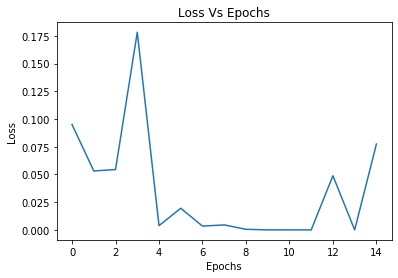

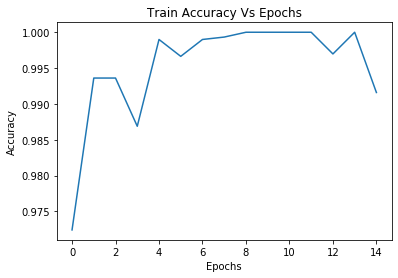

In [13]:
train = MLPModel()
maml, loss, accuracies = train_maml(train,task_data,task_label,15)

In [14]:
testpath = r'/home/giang/Lab/Code/Trainsets' # use your path
testclasses = {0:'P0-W0', 1:'P1-W1', 2:'P9-W7', 3:'P14-W0'}

df_test, x_np_test, y_np_test = {}, {}, {}

for i, cls in testclasses.items():
    print(i, cls)
    all_files = glob.glob(testpath + "/" + cls + "/*.csv")
    df_test[i] = pd.concat((pd.read_csv(f, header=None) for f in all_files))
    x_np_test[i] = np.transpose(np.array(df_test[i]))
    print(x_np_test[i].shape)
   
    y_np_test[i] = np.ones(len(x_np_test[i])) * i # Target label
    print(y_np_test[i].shape)

0 P0-W0
(373, 504)
(373,)
1 P1-W1
(361, 504)
(361,)
2 P9-W7
(476, 504)
(476,)
3 P14-W0
(461, 504)
(461,)


In [15]:
num_tasks_test = min(len(x_np_test[i]) for i in range(len(testclasses))) 
print(num_tasks_test)

361


In [16]:
task_data_test = {}
task_label_test = {}
for i in range(num_tasks_test):
    task_data_test[i] = np.stack([x_np_test[k][i] for k in range(len(testclasses))],axis=0)
    task_label_test[i] = np.stack([y_np_test[k][i] for k in range(len(testclasses))],axis=0)
    task_label_test[i] = task_label_test[i].reshape(-1,1)
print(task_data_test[0].shape)
print(task_label_test[0].shape)

(4, 504)
(4, 1)


In [17]:
data_label_test = {}
for i in range(num_tasks_test):
    data_label_test[i] = np.concatenate((task_data_test[i],task_label_test[i]),axis=1)
    np.random.shuffle(data_label_test[i])
    task_data_test[i],task_label_test[i] = np.split(data_label_test[i],[-1],axis=1)
    task_label_test[i] = to_categorical(task_label_test[i])
print(task_data_test[0].shape)
print(task_label_test[0].shape)

(4, 504)
(4, 4)


In [24]:
def adaptation(model, optimizer, data_test, label_test, num_steps = 10, log_step =1):
    losses = []
    accuracies = []
    # If 0 in fits we log the loss before any training

    totalacc = 0
    totalloss = 0
    for k in range(len(testclasses)):
        curr_loss, curr_logits = compute_loss(model, data_test[k,:].reshape(1,-1), label_test[k])
        curr_acc = accuracy_function(label_test[k],curr_logits)
        totalloss += curr_loss
        task_loss = totalloss / (k+1)
        totalacc += curr_acc
        task_acc = totalacc / (k+1)   
    losses.append(task_loss)
    accuracies.append(task_acc)
        
    for step in range(1, num_steps):
        for k in range(len(testclasses)):
            train_batch(data_test[k,:].reshape(1,-1), label_test[k], model, optimizer)
            
        totalacc = 0
        totalloss = 0
        for k in range(len(testclasses)):
            curr_loss, curr_logits = compute_loss(model, data_test[k,:].reshape(1,-1), label_test[k])
            curr_acc = accuracy_function(label_test[k],curr_logits)
            totalloss += curr_loss
            task_loss = totalloss / (k+1)
            totalacc += curr_acc
            task_acc = totalacc / (k+1)
        if step % log_step == 0:
            losses.append(task_loss)
            accuracies.append(task_acc)
    return accuracies, losses


def test(model, data, label, k = 2, num_steps=10, lr=0.01):
   
    x_test = data[k]
    y_test = label[k]
    
    # copy model so we can use the same model multiple times
    copied_model = copy_model(model, x_test)
    
    # use SGD for this part of training as described in the paper
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    
    # run training and log fit results
    accuracies, losses = adaptation(copied_model, optimizer, x_test, y_test, num_steps)
    
    # plot
    plt.figure()
    plt.plot(losses , '--')
    plt.xlabel('Adaptation Steps')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuracies , '--')
    plt.xlabel('Adaptation Steps')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)
    plt.show()

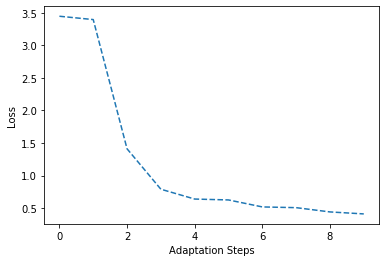

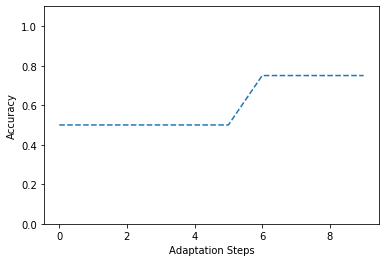

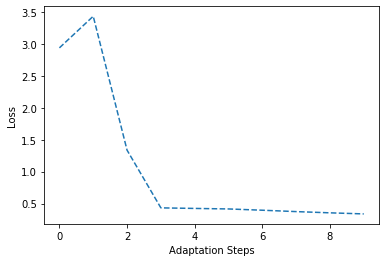

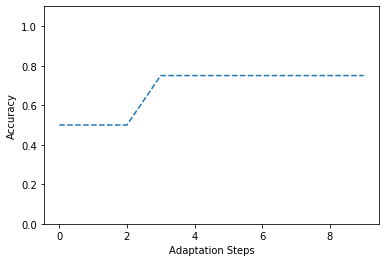

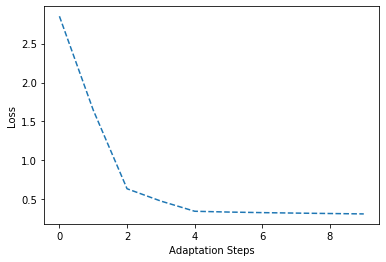

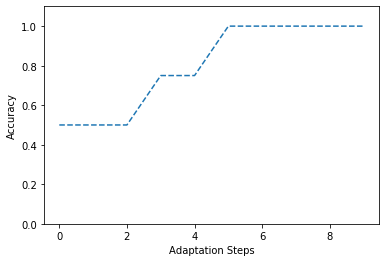

In [25]:
for i in np.random.randint(0, len(task_data_test), size=3):
    test(maml,task_data_test,task_label_test,i)